# [초급 프로젝트] 4팀_김명환 - EfficientNet모델링 테스트 및 평가

---
---

# 환경설정
    - 라이브러리 설치 및 로딩
    - 사용자 함수 사용

In [1]:
!pip install -q gdown
!pip install -q albumentations
!pip install -q ultralytics
!pip install -q -U ultralytics
!pip install -q nbformat
!pip install -q roboflow
!pip install -q opencv-python
!pip install -q opencv-python-headless
!pip install -q wandb
!pip install -q timm
!pip install -q torchvision
#!pip install -q torch torchvision tqdm pillow matplotlib

print("로딩완료")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.7/88.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 120.6 MB/s eta 0:00:00
로딩완료


In [2]:
!wandb login 86a7b8c07184b2efdfb116546a17b1905e41cb5d

wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [3]:
# 기본 라이브러리 (중복 제거 및 정리)

# --- Scikit-learn: 데이터 전처리, 모델, 평가 ---
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import (
    fetch_california_housing, load_iris, make_moons, make_circles,
    load_breast_cancer, load_wine
)
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, average_precision_score

# --- 이미지 처리 ---
import cv2
from PIL import Image, ImageFilter, ImageDraw
import albumentations as A

# --- PyTorch: 딥러닝 관련 ---
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
# 문제 있는 v2 import 제거하고 필요시에만 개별적으로 import
# from torchvision.transforms import v2, functional as TF
from torchvision.transforms import functional as TF
from torchvision.datasets import CocoDetection
from torch.nn import CrossEntropyLoss
from collections import OrderedDict

# --- COCO 데이터셋 관련 ---
from pycocotools.coco import COCO
from pycocotools import mask as coco_mask

# --- 딥러닝 모델 ---
import timm

# --- 기본 라이브러리 ---
import os
import sys
import re
import csv
import copy
import json
import math
import random
import yaml
import shutil
import requests
import xml.etree.ElementTree as ET
from pathlib import Path

# --- 데이터 분석 및 시각화 ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --- 시간 관련 ---
from datetime import datetime, timezone, timedelta
import pytz

# --- 진행률 표시 ---
import IPython.display
from tqdm.notebook import tqdm

# --- 시간대 설정 ---
__kst = pytz.timezone('Asia/Seoul')

# --- GPU 설정 ---
__device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
__device_cpu = torch.device('cpu')

# --- 재현 가능한 결과를 위한 시드 설정 ---
np.random.seed(42)
torch.manual_seed(42)
if __device.type == 'cuda':
    torch.cuda.manual_seed_all(42)

print(f"라이브러리 로드 완료 사용장치: {__device}")

라이브러리 로드 완료 사용장치: cuda


In [4]:
from urllib.request import urlretrieve; urlretrieve("https://raw.githubusercontent.com/c0z0c/jupyter_hangul/refs/heads/beta/helper_c0z0c_dev.py", "helper_c0z0c_dev.py")
import importlib
import helper_c0z0c_dev as helper
importlib.reload(helper)

🌐 https://c0z0c.github.io/jupyter_hangul
ℹ️ NumPy 2.0.2 (v2.x+): 호환성 모드 적용됨
install fonts-nanum...
✅ 설정 완료: 한글 폰트, plt 전역 등록, pandas 확장, 캐시 기능
pd commit 저장 경로 = /content/drive/MyDrive
🌐 https://c0z0c.github.io/jupyter_hangul
ℹ️ NumPy 2.0.2 (v2.x+): 호환성 모드 적용됨
Mounted at /content/drive
✅ 설정 완료: 한글 폰트, plt 전역 등록, pandas 확장, 캐시 기능
pd commit 저장 경로 = /content/drive/MyDrive


<module 'helper_c0z0c_dev' from '/content/helper_c0z0c_dev.py'>

In [5]:
# OS 및 경로 관련 라이브러리 임포트
import os, sys
from pathlib import Path

# 유틸리티 함수 디렉토리 경로 설정 (Colab 환경 여부에 따라 다르게 지정)
utils_dir = None
if helper.is_colab:
    # Colab 환경일 경우 Google Drive 경로 사용
    utils_dir = "/content/drive/MyDrive/codeit_ai_health_eat/src/python_modules/utils"
else:
    # 로컬 환경일 경우 현재 드라이브 기준 경로 사용
    utils_dir = os.path.join(Path.cwd().drive + '\\\\', 'GoogleDrive', "codeit_ai_health_eat", "src", "python_modules", "utils")

print("utils_dir:", utils_dir)

# 유틸리티 함수 경로를 파이썬 모듈 검색 경로에 추가
sys.path.append(str(utils_dir))
print("sys.path:", sys.path)

# health_ea_utils 모듈 임포트 및 최신화(reload)
import importlib
import health_ea_utils as heu
importlib.reload(heu)
from health_ea_utils import *

# helper 및 health_ea_utils 파일 경로 출력 (디버깅용)
print("helper.__file__:", helper.__file__)
print("health_ea_utils.__file__:", heu.__file__)

utils_dir: /content/drive/MyDrive/codeit_ai_health_eat/src/python_modules/utils
sys.path: ['/content', '/env/python', '/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/usr/local/lib/python3.12/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.12/dist-packages/IPython/extensions', '/root/.ipython', '/tmp/tmpc8b_8541', '/content/drive/MyDrive/codeit_ai_health_eat/src/python_modules/utils']
🌐 https://c0z0c.github.io/jupyter_hangul
ℹ️ NumPy 2.0.2 (v2.x+): 호환성 모드 적용됨
Mounted at /content/drive
✅ 설정 완료: 한글 폰트, plt 전역 등록, pandas 확장, 캐시 기능
pd commit 저장 경로 = /content/drive/MyDrive
🌐 https://c0z0c.github.io/jupyter_hangul
ℹ️ NumPy 2.0.2 (v2.x+): 호환성 모드 적용됨
Mounted at /content/drive
✅ 설정 완료: 한글 폰트, plt 전역 등록, pandas 확장, 캐시 기능
pd commit 저장 경로 = /content/drive/MyDrive
helper.__file__: /content/helper_c0z0c_dev.py
health_ea_utils.__file__: /content/drive/MyDrive/codeit_ai_health_eat/src/python_modules/utils/health_ea_utils.py


# 1. 학습용 데이타 다운로드 및 압축 풀기

In [6]:
def get_tqdm_kwargs():
    """Widget 오류를 방지하는 안전한 tqdm 설정"""
    return {
        'disable': False,
        'leave': True,
        'file': sys.stdout,
        'ascii': True,  # ASCII 문자만 사용
        'dynamic_ncols': False,
#        'ncols': 80  # 고정 폭
    }

def drive_root():
    """
    Google Drive의 최상위 경로를 반환하는 함수입니다.
    - 로컬 환경(Windows): D:\GoogleDrive
    - Colab 환경: /content/drive/MyDrive
    프로젝트 내에서 데이터, 모델, 설정 파일 등 경로를 일관되게 관리할 때 사용합니다.
    """
    root_path = os.path.join(Path.cwd().drive + '\\', "GoogleDrive")
    if helper.is_colab:
        root_path = os.path.join("/content/drive/MyDrive")
    return root_path

def get_path_modeling(add_path = None):
    """
    get_path_modeling() 함수는 모델링 관련 파일(예: 학습 결과, 체크포인트, 로그 등)을 저장할 경로를 반환합니다.
    기본적으로 Google Drive의 루트 경로(drive_root()) 아래 "modeling_yolo" 폴더를 기준으로 경로를 생성합니다.
    추가 하위 경로가 필요할 경우 add_path 인자를 통해 세부 폴더까지 지정할 수 있습니다.
    예시:
    get_path_modeling() → modeling_yolo (로컬)
    get_path_modeling("exp1") → D:\GoogleDrive\modeling_yolo\exp1
    Colab 환경에서는 /content/drive/MyDrive/modeling_yolo로 반환됩니다.
    """

    modeling_path = "modeling_yolo"
    path = os.path.join(drive_root(),modeling_path)
    if add_path is not None:
        path = os.path.join(path,add_path)
    return path

def get_path_modeling_release(add_path = None):
    """
    get_path_modeling_release() 함수는 모델링 결과물(예: 학습 결과, 체크포인트, 로그 등)을 저장할 경로를 반환합니다.
    기본적으로 Google Drive의 루트 경로(drive_root()) 아래 "modeling_yolo" 폴더를 기준으로 경로를 생성합니다.
    추가 하위 경로가 필요할 경우 add_path 인자를 통해 세부 폴더까지 지정할 수 있습니다.
    예시:
    get_path_modeling_release() → modeling_yolo (로컬)
    get_path_modeling_release("exp1") → D:\GoogleDrive\modeling_yolo\exp1
    Colab 환경에서는 /content/drive/MyDrive/modeling_yolo로 반환됩니다._
    """
    modeling_path = "modeling_yolo"
    path = os.path.join(drive_root(),modeling_path)
    if add_path is not None:
        path = os.path.join(path,add_path)
    return path

def print_dir_tree(root, max_depth=2, list_count=3, indent=""):
    """
    지정한 폴더(root) 하위의 디렉토리 구조를 트리 형태로 출력하는 함수입니다.

    Args:
        root: 시작 경로(폴더)
        max_depth: 출력할 최대 깊이(디폴트 2)
        list_count: 파일 개수가 많을 때 몇 개만 출력할지(디폴트 3)
        indent: 들여쓰기(재귀적으로 사용)
    """
    import os
    if max_depth < 0:
        return
    try:
        items = os.listdir(root)
    except Exception as e:
        print(indent + f"[Error] {e}")
        return

    img_count = len([f for f in os.listdir(root) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.xml', '.inf', '.txt'))])
    for item in items:
        path = os.path.join(root, item)
        if os.path.isdir(path):
            print(indent + "|-- "+ item)
            # 이미지 파일 개수만 출력
            img_count = len([f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.xml', '.inf', '.txt'))])
            if img_count > list_count:
                print(indent + "   "+ f"[데이터파일: {img_count}개]")
            print_dir_tree(root=path, max_depth=max_depth-1, list_count=list_count, indent=indent + "   ")
        else:
            if list_count < img_count and item.lower().endswith(('.jpg', '.jpeg', '.png', '.xml', '.inf', '.txt')):
                continue
            print(indent + "|-- "+ item)

def save_model_dict(model, path, pth_name, kwargs=None):
    """모델 state_dict와 추가 정보를 저장"""
    def safe_makedirs(path):
        """안전한 디렉토리 생성"""
        if os.path.exists(path) and not os.path.isdir(path):
            os.remove(path)  # 파일이면 삭제
        os.makedirs(path, exist_ok=True)

    # 디렉토리 생성
    safe_makedirs(path)

    # 모델 구조 정보 추출
    model_info = {
        'class_name': model.__class__.__name__,
        'init_args': {},
        'str': str(model),
        'repr': repr(model),
        'modules': [m.__class__.__name__ for m in model.modules()],
    }

    # 생성자 인자 자동 추출(가능한 경우)
    if hasattr(model, '__dict__'):
        for key in ['in_ch', 'base_ch', 'num_classes', 'out_ch']:
            if hasattr(model, key):
                model_info['init_args'][key] = getattr(model, key)

    # kwargs 처리
    extra_info = {}
    if kwargs is not None:
        if isinstance(kwargs, str):
            extra_info = json.loads(kwargs)
        elif isinstance(kwargs, dict):
            extra_info = kwargs

    model_info.update(extra_info)

    # 저장할 dict 구성
    save_dict = {
        'model_state': model.state_dict(),
        'class_name': model.__class__.__name__,
        'model_info': model_info,
    }

    save_path = os.path.join(path, f"{pth_name}.pth")
    torch.save(save_dict, save_path)
    return save_path

def load_model_dict(path, pth_name=None):
    """
    save_model_dict로 저장한 모델을 불러오는 함수
    반환값: (model_state, model_info)
    """
    import torch
    load_path = path
    if pth_name is not None:
        load_path = os.path.join(path, f"{pth_name}.pth")
    checkpoint = torch.load(load_path, map_location='cpu', weights_only=False)  # <-- 여기 추가
    model_state = checkpoint.get('model_state')
    model_info = checkpoint.get('model_info')
    model_info['file_name'] = os.path.basename(load_path)
    return model_state, model_info


def search_pth_files(base_path):
    """
    입력된 경로의 하위 폴더들에서 pth 파일들을 검색
    """
    pth_files = []

    if not os.path.exists(base_path):
        print(f"경로가 존재하지 않습니다: {base_path}")
        return pth_files

    print(f"pth 파일 검색 시작: {base_path}")

    # 하위 폴더들을 순회하며 pth 파일 검색
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith('.pth'):
                pth_path = os.path.join(root, file)
                pth_files.append(pth_path)

    # 결과 정리 및 출력
    if pth_files:
        print(f"\n발견된 pth 파일들 ({len(pth_files)}개):")
        for i, pth_file in enumerate(pth_files, 1):
            # 상대 경로로 표시 (base_path 기준)
            rel_path = os.path.relpath(pth_file, base_path)
            print(f" {i:2d}. {rel_path}")
    else:
        print("pth 파일을 찾을 수 없습니다.")

    return pth_files

def print_json_tree(data, indent="", max_depth=4, _depth=0, list_count=2, print_value=True):
    """
    JSON 객체를 지정한 단계(max_depth)까지 트리 형태로 출력
    - list 타입은 3개 이상일 때 개수만 출력
    - 하위 노드가 값일 경우 key(type) 형태로 출력
    - print_value=True일 때 key(type): 값 형태로 출력
    """
    if _depth > max_depth:
        return
    if isinstance(data, dict):
        for key, value in data.items():
            if isinstance(value, (dict, list)):
                print(f"{indent}|-- {key}")
                print_json_tree(value, indent + "    ", max_depth, _depth + 1, list_count, print_value)
            else:
                if print_value:
                    print(f"{indent}|-- {key}({type(value).__name__}): {value if len(str(value)) < 100 else f'{str(value)[:30]}...'}")
                else:
                    print(f"{indent}|-- {key}({type(value).__name__})")
    elif isinstance(data, list):
        if len(data) > list_count:
            print(f"{indent}|-- [list] ({len(data)} items)")
        else:
            for i, item in enumerate(data):
                if isinstance(item, (dict, list)):
                    print(f"{indent}|-- [{i}]")
                    print_json_tree(item, indent + "    ", max_depth, _depth + 1, list_count, print_value)
                else:
                    if print_value:
                        print(f"{indent}|-- [{i}]({type(item).__name__}): {item if len(str(item)) < 100 else f'{str(item)[:30]}...'}")
                    else:
                        print(f"{indent}|-- [{i}]({type(item).__name__})")
    else:
        if print_value:
            print(f"{indent}{type(data).__name__}: {data if len(str(data)) < 100 else f'{str(data)[:30]}...'}")
        else:
            print(f"{indent}{type(data).__name__}")

def print_git_tree(data, indent="", max_depth=3, _depth=0):
    """
    PyTorch tensor/딕셔너리/리스트를 git tree 스타일로 출력
    """
    import torch
    import numpy as np

    if _depth > max_depth:
        return
    if isinstance(data, dict):
        for key, value in data.items():
            print(f"{indent}├─ {key} [{type(value).__name__}]")
            print_git_tree(value, indent + "│  ", max_depth, _depth + 1)
    elif isinstance(data, (list, tuple)):
        for i, item in enumerate(data):
            print(f"{indent}├─ [{i}] [{type(item).__name__}]")
            print_git_tree(item, indent + "│  ", max_depth, _depth + 1)
    elif torch.is_tensor(data):
        shape = tuple(data.shape)
        dtype = str(data.dtype)
        preview = str(data)
        preview_str = preview[:80] + ("..." if len(preview) > 80 else "")
        print(f"{indent}└─ Tensor shape={shape} dtype={dtype} preview={preview_str}")
    elif isinstance(data, np.ndarray):
        shape = data.shape
        dtype = data.dtype
        preview = str(data)
        preview_str = preview[:80] + ("..." if len(preview) > 80 else "")
        print(f"{indent}└─ ndarray shape={shape} dtype={dtype} preview={preview_str}")
    else:
        val_str = str(data)
        print(f"{indent}└─ {type(data).__name__}: {val_str[:80]}{'...' if len(val_str)>80 else ''}")


print("유틸리티 함수 로드 완료")

유틸리티 함수 로드 완료


# 데이타 다운로드

In [7]:
# download_files 변수 예시 (Google Drive 및 Naver MyBox 링크)
# 여러 버전의 데이터셋 다운로드 링크를 주석으로 관리

# download_files={
#     'yolo_label_one_class' : r'https://drive.google.com/file/d/177_86k4BuT6JnFnq7ZHJtEjp7jaRbCl2/view?usp=sharing',
#     'yolo_label' : r'https://drive.google.com/file/d/1nc-WFcw7lCS7s7VGzN9Kxh80PiBBggez/view?usp=sharing',
#     'yolo_resize_one_class' : r'https://drive.google.com/file/d/1Ak0EvkMnuwvcAFvTO-zovIgVcNlROjsS/view?usp=sharing',
#     'yolo_resize' : r'https://drive.google.com/file/d/1kpo57qOJhEhrkuzUCEh57ILB5xSPVoFv/view?usp=sharing',
# }

# download_files={
#     'yolo_label' : r'https://fs.mybox.naver.com/file/download.api?resourceKey=YzB6MGN8MzQ3MjU5Nzc1ODU5OTkzNTMyOHxGfDA&svcType=MYBOX-WEB&time=1757776010785',
#     'yolo_label_one_class' : r'https://fs.mybox.naver.com/file/download.api?resourceKey=YzB6MGN8MzQ3MjU5Nzc1ODYzOTg5NDExMnxGfDA&svcType=MYBOX-WEB&time=1757776673721',
#     'yolo_resize_one_class' : r'https://fs.mybox.naver.com/file/download.api?resourceKey=YzB6MGN8MzQ3MjU5Nzc1ODgwNjk2NDMyMHxGfDA&svcType=MYBOX-WEB&time=1757780142635',
#     'yolo_resize' : r'https://fs.mybox.naver.com/file/download.api?resourceKey=YzB6MGN8MzQ3MjU5Nzc1ODY4MDc2MjQ2NHxGfDA&svcType=MYBOX-WEB&time=1757780177672',
# }

# 실제로 사용할 데이터셋 다운로드 링크만 활성화
download_files={
    # 'yolo_label' : r'https://fs.mybox.naver.com/file/download.api?resourceKey=YzB6MGN8MzQ3MjU5Nzc1ODU5OTkzNTMyOHxGfDA&svcType=MYBOX-WEB&time=1757776010785',
    # 'yolo_label_one_class' : r'https://fs.mybox.naver.com/file/download.api?resourceKey=YzB6MGN8MzQ3MjU5Nzc1ODYzOTg5NDExMnxGfDA&svcType=MYBOX-WEB&time=1757776673721',
    # 'yolo_resize_one_class' : r'https://fs.mybox.naver.com/file/download.api?resourceKey=YzB6MGN8MzQ3MjU5Nzc1ODgwNjk2NDMyMHxGfDA&svcType=MYBOX-WEB&time=1757780142635',
    # 'yolo_resize' : r'https://fs.mybox.naver.com/file/download.api?resourceKey=YzB6MGN8MzQ3MjU5Nzc1ODY4MDc2MjQ2NHxGfDA&svcType=MYBOX-WEB&time=1757780177672',
    'yolo_noresize' : r'https://fs.mybox.naver.com/file/download.api?resourceKey=YzB6MGN8MzQ3MjU5Nzc2NDA0ODY2ODI1NnxGfDA&svcType=MYBOX-WEB&time=1757851996107',
    # 'yolo_noresize_one_class':r'https://fs.mybox.naver.com/file/download.api?resourceKey=YzB6MGN8MzQ3MjU5Nzc2NDgwMDcxODk0NHxGfDA&svcType=MYBOX-WEB&time=1757893856220',
}

# 참고용: 각 데이터셋의 직접 다운로드 링크
# yolo_noresize = https://fs.mybox.naver.com/file/download.api?resourceKey=YzB6MGN8MzQ3MjU5Nzc2NDA0ODY2ODI1NnxGfDA&svcType=MYBOX-WEB&time=1757851996107
# yolo_noresize_one_class = https://fs.mybox.naver.com/file/download.api?resourceKey=YzB6MGN8MzQ3MjU5Nzc2NDgwMDcxODk0NHxGfDA&svcType=MYBOX-WEB&time=1757893856220


In [8]:
import gdown
def download_gdrive_file(url, output_path, ignore=True):
    """Google Drive 파일 다운로드 함수

    Args:
        url (str): Google Drive 공유 링크
        output_path (str): 다운로드할 파일 경로
        ignore (bool, optional): True면 기존 파일 삭제 후 다운로드, False면 파일 있으면 건너뜀. Defaults to True.

    Raises:
        ValueError: Google Drive 파일 ID를 찾을 수 없습니다.
    """
    # 공유 링크에서 파일 ID 추출
    if os.path.exists(output_path):
        if ignore:
            os.remove(output_path)
        else:
            return

    file_id_match = re.search(r'/d/([a-zA-Z0-9_-]+)', url)
    if not file_id_match:
        raise ValueError("Google Drive 파일 ID를 찾을 수 없습니다.")
    file_id = file_id_match.group(1)
    gdown.download(f"https://drive.google.com/uc?id={file_id}", output_path, quiet=False)

def download_http(url, target, ignore=True):
    """
    HTTP 파일 다운로드 함수 (진행률 표시)
    url: 다운로드할 파일 URL
    target: 저장할 파일 경로
    ignore: True면 기존 파일 삭제 후 다운로드, False면 파일 있으면 건너뜀
    """
    if os.path.exists(target):
        if ignore:
            os.remove(target)
        else:
            print(f"이미 파일이 존재합니다: {target}")
            return target

    response = requests.get(url, stream=True)
    total = int(response.headers.get('content-length', 0))
    with open(target, 'wb') as file, tqdm(
        desc=f"Downloading {os.path.basename(target)}",
        total=total,
        unit='B',
        unit_scale=True,
        unit_divisor=1024,
        ascii=True
    ) as bar:
        for data in response.iter_content(chunk_size=1024):
            size = file.write(data)
            bar.update(size)
    print(f"다운로드 완료: {target}")
    return target

# local_code_it_ai04 = os.path.join( '~/.cache/' if helper.is_colab else Path.cwd().drive + '\\'
#                                   ,'temp'
#                                   , 'code_it_ai04')

# 데이터 다운로드 및 압축 해제 코드에 상세 주석 추가

# 다운로드 경로 설정 (Colab/로컬 환경에 따라 다름)
if helper.is_colab:
    local_code_it_ai04 = os.path.join( '/content/', 'code_it_ai04')
else:
    local_code_it_ai04 = os.path.join( Path.cwd().drive + '\\\\', 'temp', 'code_it_ai04')

print("local_code_it_ai04:", local_code_it_ai04)

os.makedirs(local_code_it_ai04, exist_ok=True)  # 폴더 생성 코드 추가

unzip_paths = []
for key, url in download_files.items():
    print(f"{key}: {url}")
    zipfile = os.path.join(local_code_it_ai04, f'{key}.zip')
    unzip_path = os.path.join(local_code_it_ai04, f'{key}.zip.unzip')
    # 이미 압축해제된 폴더가 있으면 재다운로드/압축해제하지 않음
    if os.path.exists(unzip_path):
        print(f"이미 압축해제된 폴더가 존재합니다: {unzip_path}")
        print('unzipfile:', unzip_path)
        unzip_paths.append(unzip_path)
        continue
    # Google Drive 파일 다운로드 함수 (주석처리, 필요시 사용)
    #download_gdrive_file(url, os.path.join(local_code_it_ai04, f'{key}.zip'), ignore=False)
    # 일반 HTTP 다운로드 함수 사용
    download_http(url, zipfile, ignore=False)
    # 압축 해제 (health_ea_utils의 unzip 함수 사용)
    unzip_path_list = heu.unzip([os.path.join(local_code_it_ai04, f'{key}.zip')])
    # 압축 해제된 경로 리스트 출력 및 저장
    print('unzip_path_list:', unzip_path_list)
    unzip_paths.extend(unzip_path_list)


local_code_it_ai04: /content/code_it_ai04
yolo_noresize: https://fs.mybox.naver.com/file/download.api?resourceKey=YzB6MGN8MzQ3MjU5Nzc2NDA0ODY2ODI1NnxGfDA&svcType=MYBOX-WEB&time=1757851996107


다운로드 완료: /content/code_it_ai04/yolo_noresize.zip


압축 해제 중: yolo_noresize.zip: 100%|██████████| 3822/3822 [00:02<00:00, 1748.51file/s]

압축 해제 완료: /content/code_it_ai04/yolo_noresize.zip.unzip
unzip_path_list: ['/content/code_it_ai04/yolo_noresize.zip.unzip']


In [9]:
# google drive root에 keggle.json 파일 필요합니다.
for path in unzip_paths:
    print("압축해제된 폴더:", path)

#yolo_dataset_path = os.path.join(local_code_it_ai04, f'yolo_label_one_class.zip.unzip')
yolo_dataset_path =unzip_paths[0]
yaml_path = os.path.join(yolo_dataset_path, "dataset.yaml")

def get_path_data():
    path = yolo_dataset_path
    return path

print("yaml_path:", yaml_path)
print("get_path_data:", get_path_data())

압축해제된 폴더: /content/code_it_ai04/yolo_noresize.zip.unzip
yaml_path: /content/code_it_ai04/yolo_noresize.zip.unzip/dataset.yaml
get_path_data: /content/code_it_ai04/yolo_noresize.zip.unzip


## EfficientNet 모델링

In [10]:
from pathlib import Path
from ultralytics import YOLO

# GPU 확인
device = __device
print(f"사용 디바이스: {device}")
print(f"CUDA 버전: {torch.version.cuda}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
사용 디바이스: cuda
CUDA 버전: 12.6


In [11]:
for path in unzip_paths:
    print(f"압축해제된 폴더: {path}")


압축해제된 폴더: /content/code_it_ai04/yolo_noresize.zip.unzip


In [12]:
class YOLOToClassificationDataset(Dataset):
    """
    YOLO 형식의 객체 감지 데이터셋을 이미지 분류용 데이터셋으로 변환하는 클래스입니다.

    - yaml_path: YOLO 데이터셋의 dataset.yaml 파일 경로
    - split: 'train', 'val', 'test' 중 하나로 데이터 분할 선택
    - transform: 이미지 전처리(transform) 함수 (torchvision.transforms 등)
    - crop_objects: True일 경우, 바운딩 박스(bbox) 영역만 crop하여 분류 이미지로 사용

    주요 동작:
    1. yaml 파일에서 이미지/라벨 폴더 경로, 클래스 정보 등을 읽어옴
    2. 각 라벨(txt) 파일을 읽어, 이미지 경로와 클래스, bbox 정보를 self.data에 저장
    3. __getitem__에서 bbox 영역 crop 후 transform 적용, (이미지, 클래스ID) 반환
    4. get_item은 추가로 원본 이미지 경로와 bbox 좌표도 반환 (샘플 저장 등에 활용)

    예시 사용법:
        dataset = YOLOToClassificationDataset(yaml_path, split='train', transform=...)
        image, label = dataset[0]
    """


    def __init__(self, yaml_path, split='train', transform=None, crop_objects=True):
        """YOLOToClassificationDataset 초기화

        Args:
            yaml_path (str): YOLO 데이터셋의 dataset.yaml 파일 경로
            split (str, optional): 'train', 'val', 'test' 중 하나로 데이터 분할 선택. Defaults to 'train'.
            transform (callable, optional): 이미지 전처리(transform) 함수 (torchvision.transforms 등). Defaults to None.
            crop_objects (bool, optional): True일 경우, 바운딩 박스(bbox) 영역만 crop하여 분류 이미지로 사용. Defaults to True.

        Raises:
            ValueError: 잘못된 split 값이 주어진 경우
        """
        # yaml 파일 읽기
        with open(yaml_path, 'r') as f:
            yaml_data = yaml.safe_load(f)

        self.yaml_data_path = yaml_data['path']
        self.nc = yaml_data['nc']
        self.names = yaml_data['names']
        self.yaml_data_train = os.path.join(yaml_data['path'], yaml_data['train'])
        self.yaml_data_val = os.path.join(yaml_data['path'], yaml_data['val'])
        self.yaml_data_test = os.path.join(yaml_data['path'], yaml_data['test'])

        #print("nc:", self.nc)
        #print("names:", self.names)
        print("yaml_data_path:", self.yaml_data_path)
        #print("yaml_data_train:", self.yaml_data_train)
        #print("yaml_data_val:", self.yaml_data_val)
        #print("yaml_data_test:", self.yaml_data_test)

        # split에 따라 경로 선택
        if split == 'train':
            image_dir = self.yaml_data_train
        elif split == 'val':
            image_dir = self.yaml_data_val
        elif split == 'test':
            image_dir = self.yaml_data_test
        else:
            raise ValueError(f"split 값이 잘못되었습니다: {split}")

        label_dir = image_dir.replace('images', 'labels')
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.class_names = self.names
        self.transform = transform
        self.crop_objects = crop_objects
        self.data = []

        self._load_data()

    def _load_data(self):
        """
        데이터셋을 로드하는 함수

        - 라벨 디렉토리(self.label_dir) 내의 모든 .txt 파일(객체 감지 라벨)을 순회합니다.
        - 각 라벨 파일의 한 줄(line)은 하나의 객체(알약)에 대한 정보입니다.
        - 각 줄에서 class_id, bbox(x_center, y_center, width, height)를 읽어옵니다.
        - 해당 라벨 파일에 대응하는 이미지 파일(.jpg)을 찾고, 존재하면
        이미지 경로, 클래스ID, 바운딩박스 정보를 self.data 리스트에 저장합니다.
        - 즉, 한 알약(객체)마다 하나의 데이터 샘플이 만들어집니다.
        - 이후 __getitem__에서 bbox 영역만 crop(클리핑)하여 분류용 이미지로 반환합니다.

        반환값: 없음 (self.data에 샘플 정보가 누적됨)
        """

        if not os.path.exists(self.label_dir):
            #print(f"라벨 폴더가 존재하지 않습니다: {self.label_dir}")
            return  # 라벨 폴더 없으면 빈 데이터셋
        for label_file in os.listdir(self.label_dir):
            if not label_file.endswith('.txt'):
                continue
            image_file = label_file.replace('.txt', '.jpg')
            image_path = os.path.join(self.image_dir, image_file)
            label_path = os.path.join(self.label_dir, label_file)
            if not os.path.exists(image_path):
                continue
            with open(label_path, 'r') as f:
                lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 5:
                    class_id = int(parts[0])
                    x_center, y_center, width, height = map(float, parts[1:5])
                    self.data.append({
                        'image_path': image_path,
                        'class_id': class_id,
                        'bbox': (x_center, y_center, width, height)
                    })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        데이터셋에서 특정 인덱스의 샘플을 가져오는 함수

        - self.data에서 idx번째 샘플 정보를 가져옵니다.
        - 해당 이미지 파일을 열고, crop_objects=True일 경우 바운딩 박스(bbox) 영역만 crop(클리핑)합니다.
        - 이미지 전처리(transform)가 지정되어 있으면 적용합니다.
        - 최종적으로 (이미지, 클래스ID)를 반환합니다.

        즉, 한 알약 객체의 crop된 이미지와 클래스 라벨을 반환합니다.
        """

        item = self.data[idx]
        image = Image.open(item['image_path']).convert('RGB')
        if self.crop_objects and 'bbox' in item:
            img_w, img_h = image.size
            x_center, y_center, width, height = item['bbox']
            x1 = int((x_center - width/2) * img_w)
            y1 = int((y_center - height/2) * img_h)
            x2 = int((x_center + width/2) * img_w)
            y2 = int((y_center + height/2) * img_h)
            # 좌표가 올바른지 체크
            if x2 > x1 and y2 > y1 and x1 >= 0 and y1 >= 0 and x2 <= img_w and y2 <= img_h:
                image = image.crop((x1, y1, x2, y2))
            # else: 잘못된 bbox는 crop하지 않음
        if self.transform:
            image = self.transform(image)
        return image, item['class_id']

    def get_item(self, idx):
        """
        데이터셋에서 특정 인덱스의 샘플을 가져오는 함수

        - self.data에서 idx번째 샘플 정보를 가져옵니다.
        - 해당 이미지 파일을 열고, crop_objects=True일 경우 바운딩 박스(bbox) 영역만 crop(클리핑)합니다.
        - 이미지, 클래스ID, 원본 이미지 경로, bbox 좌표([x1, y1, x2, y2])를 반환합니다.
        - 샘플 이미지 저장, 시각화 등에 활용할 수 있습니다.

        즉, 한 알약 객체의 crop된 이미지와 클래스 라벨, 원본 경로, bbox 좌표를 반환합니다.
        """

        item = self.data[idx]
        image = Image.open(item['image_path']).convert('RGB')
        if self.crop_objects and 'bbox' in item:
            img_w, img_h = image.size
            x_center, y_center, width, height = item['bbox']
            x1 = int((x_center - width/2) * img_w)
            y1 = int((y_center - height/2) * img_h)
            x2 = int((x_center + width/2) * img_w)
            y2 = int((y_center + height/2) * img_h)
            # 좌표가 올바른지 체크
            if x2 > x1 and y2 > y1 and x1 >= 0 and y1 >= 0 and x2 <= img_w and y2 <= img_h:
                image = image.crop((x1, y1, x2, y2))
            # else: 잘못된 bbox는 crop하지 않음
        return image, item['class_id'], item['image_path'], [x1, y1, x2, y2]


In [13]:

# 데이터 전처리 파이프라인
def get_transforms():
    """
    데이터 전처리 변환을 정의하는 함수 (비율 유지, 224x224)
    """
    train_transform = transforms.Compose([
        transforms.Resize(224),               # 짧은 변 기준 224로 리사이즈 (비율 유지)
        transforms.CenterCrop(224),           # 중앙에서 224x224 crop
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    return train_transform, val_transform

def create_resnet_model(num_classes, model_type='resnet50', pretrained=False):
    """사전 학습된 ResNet 모델 로드"""
    from torchvision.models import resnet18, resnet34, resnet50, resnet101, resnet152

    model_dict = {
        'resnet18': resnet18,
        'resnet34': resnet34,
        'resnet50': resnet50,
        'resnet101': resnet101,
        'resnet152': resnet152
    }

    if model_type not in model_dict:
        raise ValueError(f"지원하지 않는 모델입니다: {model_type}. 지원 모델: {list(model_dict.keys())}")

    model = model_dict[model_type](pretrained=pretrained)

    # 마지막 FC layer를 원하는 클래스 수로 변경
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(model.fc.in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)
    )

    return model

# 학습 함수
def train_epoch(model, dataloader, criterion, optimizer, device):
    """
    한 에폭 동안 모델을 학습하는 함수

    Args:
        model: 학습할 모델 (nn.Module)
        dataloader: 학습 데이터 로더
        criterion: 손실 함수 (예: nn.CrossEntropyLoss)
        optimizer: 최적화 알고리즘 (예: Adam)
        device: 연산 디바이스 (cpu 또는 cuda)

    Returns:
        평균 손실값, 정확도(%)
    """

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        pbar.set_postfix({
            'Loss': f'{running_loss/len(dataloader):.4f}',
            'Acc': f'{100*correct/total:.2f}%'
        })

    return running_loss/len(dataloader), 100*correct/total

# 검증 함수
def validate(model, dataloader, criterion, device):
    """
    모델을 검증하는 함수

    Args:
        model: 검증할 모델 (nn.Module)
        dataloader: 검증 데이터 로더
        criterion: 손실 함수 (예: nn.CrossEntropyLoss)
        device: 연산 디바이스 (cpu 또는 cuda)

    Returns:
        평균 손실값, 정확도(%)
    """

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Validating'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return running_loss/len(dataloader), 100*correct/total


In [14]:
def update_yaml_paths_to_absolute(yaml_path):
    """
    dataset.yaml 파일의 상대 경로(path)를 절대 경로로 변환하여 저장하는 함수

    Args:
        yaml_path (str): dataset.yaml 파일의 경로

    Returns:
        dict: 절대 경로로 수정된 yaml 데이터 딕셔너리
    """

    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)

    yaml_dir = os.path.dirname(yaml_path)
    data['path'] = os.path.normpath(os.path.join(yaml_dir, data['path']))
    # for key in ['train', 'val', 'test']:
    #     if key in data and not os.path.isabs(data[key]):
    #         data[key] = os.path.normpath(os.path.join(yaml_dir, data[key]))

    with open(yaml_path, 'w') as f:
        yaml.dump(data, f, allow_unicode=True)

    return data

yaml_data = update_yaml_paths_to_absolute(yaml_path)
print(yaml_data.keys())
yaml_data_path = yaml_data['path']
nc = yaml_data['nc']
names = yaml_data['names']
yaml_data_train = os.path.join(yaml_data['path'], yaml_data['train'])
yaml_data_val = os.path.join(yaml_data['path'], yaml_data['val'])
yaml_data_test = os.path.join(yaml_data['path'], yaml_data['test'])

print("nc:", nc)
print("names:", names)
print("yaml_data_path:", yaml_data_path)
print("yaml_data_train:", yaml_data_train)
print("yaml_data_val:", yaml_data_val)
print("yaml_data_test:", yaml_data_test)


dict_keys(['names', 'nc', 'path', 'test', 'train', 'val'])
nc: 73
names: [1899, 2482, 3350, 3482, 3543, 3742, 3831, 4377, 4542, 5093, 5885, 6191, 6562, 10220, 12080, 12246, 12419, 12777, 13394, 13899, 16231, 16261, 16547, 16550, 16687, 18109, 18146, 18356, 19231, 19551, 19606, 19860, 20013, 20237, 20876, 21025, 21324, 21770, 22073, 22346, 22361, 22626, 23202, 23222, 24849, 25366, 25437, 25468, 27652, 27732, 27776, 27925, 27992, 28762, 29344, 29450, 29666, 29870, 30307, 31704, 31862, 31884, 32309, 33008, 33207, 33877, 33879, 34596, 35205, 36636, 38161, 41767, 44198]
yaml_data_path: /content/code_it_ai04/yolo_noresize.zip.unzip
yaml_data_train: /content/code_it_ai04/yolo_noresize.zip.unzip/images/train
yaml_data_val: /content/code_it_ai04/yolo_noresize.zip.unzip/images/val
yaml_data_test: /content/code_it_ai04/yolo_noresize.zip.unzip/images/test


In [15]:
# raise ValueError("중단")

In [16]:
# sample image
def save_sample(dataset, save_dir, type, num_samples=5):
    """
    샘플 이미지를 저장하는 함수

    Args:
        dataset (Dataset): YOLOToClassificationDataset 등 분류용 데이터셋 객체
        save_dir (str): 이미지를 저장할 폴더 경로
        type (str): 'train', 'val', 'test' 등 데이터 분할 타입
        num_samples (int, optional): 저장할 샘플 개수. 기본값 5

    동작:
        - dataset에서 num_samples만큼 샘플을 가져와서
        - crop된 이미지를 save_dir/images/type/에 저장
        - 라벨을 save_dir/labels/type/에 txt로 저장
        - 파일명: 원본이미지명_클래스명.jpg, .txt
    """
    os.makedirs(save_dir, exist_ok=True)
    pbar = tqdm(range(min(num_samples, len(dataset))), desc="샘플 이미지 저장 중")
    for i in pbar:
        image, label, class_image_path, bbox = dataset.get_item(i)
        base_file_name = os.path.basename(class_image_path).split('.')[0]
        class_name = dataset.class_names[label]
        image_path = os.path.join(save_dir, 'images', type, f'{base_file_name}_{class_name}.jpg')
        os.makedirs(os.path.dirname(image_path), exist_ok=True)  # 폴더 생성 추가
        # 텐서를 PIL 이미지로 변환
        if isinstance(image, torch.Tensor):
            image = TF.to_pil_image(image)
        image.save(image_path)
        label_path = os.path.join(save_dir, 'labels', type, f'{base_file_name}_{class_name}.txt')
        os.makedirs(os.path.dirname(label_path), exist_ok=True)  # 폴더 생성 추가
        with open(label_path, 'w') as f:
            f.write(f"{label}\n")
        pbar.set_postfix_str(f'{base_file_name}_{class_name}')

def save_classification_yaml(save_dir, class_names):
    """
    분류용 데이터셋 yaml 파일을 저장하는 함수

    Args:
        save_dir (str): yaml 파일을 저장할 폴더 경로
        class_names (list): 클래스 이름 리스트

    동작:
        - save_dir/dataset.yaml 파일로 저장
        - 기본 구조: path, train, val, test, nc, names
    """

    yaml_dict = {
        'path': '.',
        'train': 'images/train',
        'val': 'images/val',
        'test': 'images/test',
        'nc': len(class_names),
        'names': class_names
    }
    yaml_path = os.path.join(save_dir, 'dataset.yaml')
    with open(yaml_path, 'w', encoding='utf-8') as f:
        yaml.dump(yaml_dict, f, allow_unicode=True)
    print(f'dataset.yaml 저장: {yaml_path}')

def save_yaml_sample_images():
    """
    YOLO dataset.yaml 기반으로 train/val/test 분할된 알약 crop 이미지를
    새로운 분류용 데이터셋 폴더(yaml_data_path_one)에 저장하고,
    해당 폴더에 분류용 dataset.yaml도 생성합니다.
    """

    yaml_data = update_yaml_paths_to_absolute(yaml_path)
    print(yaml_data.keys())
    yaml_data_path = yaml_data['path']
    nc = yaml_data['nc']
    names = yaml_data['names']
    yaml_data_train = os.path.join(yaml_data['path'], yaml_data['train'])
    yaml_data_val = os.path.join(yaml_data['path'], yaml_data['val'])
    yaml_data_test = os.path.join(yaml_data['path'], yaml_data['test'])


    CLASS_NAMES = names
    NUM_CLASSES = len(CLASS_NAMES)
    BATCH_SIZE = 16
    LEARNING_RATE = 0.001
    NUM_EPOCHS = 10
    # ========================================

    # 데이터셋 및 데이터로더 생성
    train_transform, val_transform = get_transforms()

    # 전체 데이터셋 (실제로는 train/val 분할 필요)
    train_dataset = YOLOToClassificationDataset(
        yaml_path = yaml_path,
        split='train',
        transform=train_transform
    )
    val_dataset = YOLOToClassificationDataset(
        yaml_path = yaml_path,
        split='val',
        transform=val_transform
    )
    test_dataset = YOLOToClassificationDataset(
        yaml_path = yaml_path,
        split='test',
        transform=val_transform
    )
    yaml_data_sample_images_train_path = os.path.join(f"{yaml_data_path}_one")
    yaml_data_sample_images_val_path = os.path.join(f"{yaml_data_path}_one")
    save_sample(train_dataset, yaml_data_sample_images_train_path, 'train', num_samples=len(train_dataset))
    save_sample(val_dataset, yaml_data_sample_images_val_path, 'val', num_samples=len(val_dataset))
    save_classification_yaml(yaml_data_sample_images_train_path, CLASS_NAMES)
    print("샘플 이미지 저장 완료")

# 알약 별로 이미지를 분리한 후 저장
# save_yaml_sample_images()

In [17]:
def analyze_class_distribution(dataset):
    """
    데이터셋의 클래스 분포를 분석하는 함수

    Args:
        dataset: YOLOToClassificationDataset 객체

    Returns:
        class_counts: 각 클래스별 샘플 수 딕셔너리
        class_distribution: 클래스 분포 정보
    """
    class_counts = {}

    # 각 클래스별 샘플 수 계산
    pbar = tqdm(range(len(dataset)), desc="클래스 분포 분석 중")
    for i in pbar:
        _, class_id = dataset[i]
        class_name = dataset.class_names[class_id]
        class_counts[class_name] = class_counts.get(class_name, 0) + 1

    # 분포 정보 계산
    total_samples = len(dataset)
    max_samples = max(class_counts.values())
    min_samples = min(class_counts.values())

    print("=" * 50)
    print("클래스 분포 분석")
    print("=" * 50)
    print(f"전체 샘플 수: {total_samples}")
    print(f"클래스 수: {len(class_counts)}")
    print(f"최대 샘플 수: {max_samples}")
    print(f"최소 샘플 수: {min_samples}")
    print(f"불균형 비율: {max_samples/min_samples:.2f}:1")
    print("\n클래스별 분포:")

    # 클래스별 상세 정보 출력
    sorted_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
    for class_name, count in sorted_classes:
        percentage = (count / total_samples) * 100
        print(f"  {class_name}: {count:4d} samples ({percentage:5.1f}%)")

    return class_counts, {
        'total_samples': total_samples,
        'num_classes': len(class_counts),
        'max_samples': max_samples,
        'min_samples': min_samples,
        'imbalance_ratio': max_samples/min_samples
    }

def create_balanced_dataset_with_augmentation(original_dataset, target_samples_per_class=None):
    """
    클래스 불균형을 해소하기 위해 데이터 증강을 적용한 균형 잡힌 데이터셋 생성

    Args:
        original_dataset: 원본 YOLOToClassificationDataset
        target_samples_per_class: 각 클래스당 목표 샘플 수 (None일 경우 최대 클래스 수로 설정)

    Returns:
        balanced_dataset: 균형 잡힌 데이터셋
    """
    from torch.utils.data import ConcatDataset

    # 클래스 분포 분석
    class_counts, _ = analyze_class_distribution(original_dataset)

    if target_samples_per_class is None:
        target_samples_per_class = max(class_counts.values())

    print(f"\n목표 클래스당 샘플 수: {target_samples_per_class}")

    # 각 클래스별 인덱스 수집
    class_indices = {}
    for i in range(len(original_dataset)):
        _, class_id = original_dataset[i]
        class_name = original_dataset.class_names[class_id]
        if class_name not in class_indices:
            class_indices[class_name] = []
        class_indices[class_name].append(i)

    # 증강된 데이터셋 리스트
    augmented_datasets = []

    # 원본 데이터셋은 기본으로 포함
    augmented_datasets.append(original_dataset)

    # 각 클래스별로 부족한 샘플을 증강으로 보충
    for class_name, indices in class_indices.items():
        current_count = len(indices)
        needed_samples = target_samples_per_class - current_count

        if needed_samples > 0:
            print(f"{class_name}: {current_count} → {target_samples_per_class} (+{needed_samples} 증강)")

            strong_augment = transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                transforms.RandomRotation(180),  # 현재 설정 유지
                transforms.ColorJitter(
                    brightness=0.2,    # 조명 변화 (현재 0.3 → 0.2로 약간 완화)
                    contrast=0.25,     # 대비 변화
                    saturation=0.15,   # 채도는 약간만 (알약 색상이 중요한 식별 요소)
                    hue=0.05          # 색조 변화 최소화 (색상이 바뀌면 다른 약으로 인식될 수 있음)
                ),
                transforms.RandomAffine(
                    degrees=0,            # 회전은 위에서 처리했으므로 0
                    translate=(0.1, 0.1), # 현재 설정 유지
                    scale=(0.95, 1.05)    # 크기 변화 더 보수적으로
                ),
                transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),  # 블러 강도 조금 완화
                # 추가 고려사항: 실제 촬영 조건
                transforms.RandomApply([
                    transforms.ColorJitter(brightness=0.4)  # 가끔 강한 조명 변화
                ], p=0.3),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

            # 해당 클래스의 인덱스로 서브셋 생성 후 증강 적용
            class_subset = Subset(original_dataset, indices)

            # 필요한 만큼 반복해서 증강 데이터 생성
            augment_iterations = (needed_samples + len(indices) - 1) // len(indices)

            for _ in range(augment_iterations):
                # 증강된 데이터셋 생성
                augmented_class_dataset = AugmentedDataset(class_subset, strong_augment)
                augmented_datasets.append(augmented_class_dataset)
        else:
            print(f"{class_name}: {current_count} (증강 불필요)")

    # 모든 데이터셋 결합
    balanced_dataset = ConcatDataset(augmented_datasets)

    print(f"\n균형 조정 완료:")
    print(f"원본 샘플 수: {len(original_dataset)}")
    print(f"증강 후 샘플 수: {len(balanced_dataset)}")

    return balanced_dataset

class AugmentedDataset(Dataset):
    """
    기존 데이터셋에 강한 증강을 적용하는 래퍼 클래스
    """
    def __init__(self, base_dataset, transform):
        self.base_dataset = base_dataset
        self.transform = transform

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        # 원본 데이터 가져오기 (transform 적용 전)
        original_dataset = self.base_dataset.dataset
        original_idx = self.base_dataset.indices[idx]

        # 원본 이미지를 PIL 형태로 가져오기
        item = original_dataset.data[original_idx]
        image = Image.open(item['image_path']).convert('RGB')

        # bbox crop 적용
        if original_dataset.crop_objects and 'bbox' in item:
            img_w, img_h = image.size
            x_center, y_center, width, height = item['bbox']
            x1 = int((x_center - width/2) * img_w)
            y1 = int((y_center - height/2) * img_h)
            x2 = int((x_center + width/2) * img_w)
            y2 = int((y_center + height/2) * img_h)

            if x2 > x1 and y2 > y1 and x1 >= 0 and y1 >= 0 and x2 <= img_w and y2 <= img_h:
                image = image.crop((x1, y1, x2, y2))

        # 강한 증강 적용
        if self.transform:
            image = self.transform(image)

        return image, item['class_id']

# 균형 잡힌 데이터셋을 사용한 학습 함수
def create_balanced_train_dataset(yaml_path, train_transform):
    """
    균형 잡힌 학습 데이터셋 생성
    """
    # 원본 학습 데이터셋 생성
    original_train_dataset = YOLOToClassificationDataset(
        yaml_path=yaml_path,
        split='train',
        transform=train_transform
    )

    # 클래스 분포 분석
    analyze_class_distribution(original_train_dataset)

    # 균형 잡힌 데이터셋 생성
    balanced_train_dataset = create_balanced_dataset_with_augmentation(
        original_train_dataset,
        target_samples_per_class=None  # 최대 클래스 수에 맞춤
    )

    return balanced_train_dataset

# 사용 예시
print("클래스 균형 조정된 데이터셋 생성 중...")

# 데이터 전처리 파이프라인
train_transform, val_transform = get_transforms()

# 균형 잡힌 학습 데이터셋 생성
train_dataset = create_balanced_train_dataset(yaml_path, train_transform)

# 검증 데이터셋은 원본 그대로 사용
val_dataset = YOLOToClassificationDataset(
    yaml_path=yaml_path,
    split='val',
    transform=val_transform
)

print("\n데이터셋 생성 완료!")
print(f"균형 조정된 학습 데이터: {len(train_dataset)} samples")
print(f"검증 데이터: {len(val_dataset)} samples")

클래스 균형 조정된 데이터셋 생성 중...
yaml_data_path: /content/code_it_ai04/yolo_noresize.zip.unzip


클래스 분포 분석 중: 100%|██████████| 3134/3134 [00:44<00:00, 69.71it/s]


클래스 분포 분석
전체 샘플 수: 3134
클래스 수: 73
최대 샘플 수: 360
최소 샘플 수: 3
불균형 비율: 120.00:1

클래스별 분포:
  3482:  360 samples ( 11.5%)
  3350:  167 samples (  5.3%)
  1899:  136 samples (  4.3%)
  2482:  111 samples (  3.5%)
  16547:  101 samples (  3.2%)
  16550:   92 samples (  2.9%)
  29666:   85 samples (  2.7%)
  35205:   82 samples (  2.6%)
  16231:   76 samples (  2.4%)
  20237:   74 samples (  2.4%)
  16261:   73 samples (  2.3%)
  36636:   72 samples (  2.3%)
  3543:   68 samples (  2.2%)
  27776:   67 samples (  2.1%)
  22346:   65 samples (  2.1%)
  27732:   65 samples (  2.1%)
  25366:   64 samples (  2.0%)
  31884:   59 samples (  1.9%)
  28762:   58 samples (  1.9%)
  34596:   55 samples (  1.8%)
  30307:   54 samples (  1.7%)
  27652:   52 samples (  1.7%)
  20876:   50 samples (  1.6%)
  25468:   48 samples (  1.5%)
  19860:   45 samples (  1.4%)
  5093:   43 samples (  1.4%)
  25437:   39 samples (  1.2%)
  3742:   37 samples (  1.2%)
  19551:   28 samples (  0.9%)
  33008:   28 samples (

클래스 분포 분석 중: 100%|██████████| 3134/3134 [00:44<00:00, 69.86it/s]


클래스 분포 분석
전체 샘플 수: 3134
클래스 수: 73
최대 샘플 수: 360
최소 샘플 수: 3
불균형 비율: 120.00:1

클래스별 분포:
  3482:  360 samples ( 11.5%)
  3350:  167 samples (  5.3%)
  1899:  136 samples (  4.3%)
  2482:  111 samples (  3.5%)
  16547:  101 samples (  3.2%)
  16550:   92 samples (  2.9%)
  29666:   85 samples (  2.7%)
  35205:   82 samples (  2.6%)
  16231:   76 samples (  2.4%)
  20237:   74 samples (  2.4%)
  16261:   73 samples (  2.3%)
  36636:   72 samples (  2.3%)
  3543:   68 samples (  2.2%)
  27776:   67 samples (  2.1%)
  22346:   65 samples (  2.1%)
  27732:   65 samples (  2.1%)
  25366:   64 samples (  2.0%)
  31884:   59 samples (  1.9%)
  28762:   58 samples (  1.9%)
  34596:   55 samples (  1.8%)
  30307:   54 samples (  1.7%)
  27652:   52 samples (  1.7%)
  20876:   50 samples (  1.6%)
  25468:   48 samples (  1.5%)
  19860:   45 samples (  1.4%)
  5093:   43 samples (  1.4%)
  25437:   39 samples (  1.2%)
  3742:   37 samples (  1.2%)
  19551:   28 samples (  0.9%)
  33008:   28 samples (

In [18]:
# raise ValueError("중단")

In [19]:
import wandb

model_name = "resnet152"

def main_modeling_with_wandb(project_name="codeit-ai-04-01", run_name=None):
    """
    EfficientNet-B3 기반 이미지 분류 모델 학습 및 평가 메인 함수

    Args:
        project_name (str, optional): W&B 프로젝트 이름. 기본값 "codeit-ai-04-01".
        run_name (str, optional): W&B 실행(run) 이름. 기본값 None.

    Returns:
        model_project_dir (str): 모델 저장 경로
        best_val_acc (float): 최고 검증 정확도(%)
    """

    yaml_data = update_yaml_paths_to_absolute(yaml_path)
    print(yaml_data.keys())
    yaml_data_path = yaml_data['path']
    nc = yaml_data['nc']
    names = yaml_data['names']
    yaml_data_train = os.path.join(yaml_data['path'], yaml_data['train'])
    yaml_data_val = os.path.join(yaml_data['path'], yaml_data['val'])
    yaml_data_test = os.path.join(yaml_data['path'], yaml_data['test'])

    CLASS_NAMES = names
    NUM_CLASSES = len(CLASS_NAMES)
    BATCH_SIZE = 16
    LEARNING_RATE = 0.001
    NUM_EPOCHS = 50

    # 모델 저장 경로 설정 (YOLO와 동일한 구조)
    #model_save_name = f"efficientnet_b3_cls_{NUM_CLASSES}classes"
    model_save_dir = get_path_modeling()
    model_project_dir = os.path.join(model_save_dir, run_name)
    os.makedirs(model_project_dir, exist_ok=True)

    print(f"모델 저장 경로: {model_project_dir}")

    # wandb 초기화
    wandb_config = {
        'model_name': model_name,
        'num_classes': NUM_CLASSES,
        'class_names': CLASS_NAMES,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'num_epochs': NUM_EPOCHS,
        'image_size': 224,
        'optimizer': 'Adam',
        'scheduler': 'StepLR',
        'pretrained': True
    }

    run = wandb.init(
        project=project_name,
        name=run_name or f"{model_name}_{NUM_CLASSES}classes_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
        config=wandb_config,
        tags=[f'{model_name}', 'classification', 'pytorch']
    )
    # ========================================

    # 데이터셋 및 데이터로더 생성
    train_transform, val_transform = get_transforms()

    train_dataset = YOLOToClassificationDataset(
        yaml_path = yaml_path,
        split='train',
        transform=train_transform
    )
    val_dataset = YOLOToClassificationDataset(
        yaml_path = yaml_path,
        split='val',
        transform=val_transform
    )
    test_dataset = YOLOToClassificationDataset(
        yaml_path = yaml_path,
        split='test',
        transform=val_transform
    )

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")

    # wandb에 데이터셋 정보 로깅
    wandb.log({
        'dataset/train_samples': len(train_dataset),
        'dataset/val_samples': len(val_dataset),
        'dataset/test_samples': len(test_dataset),
        'dataset/total_samples': len(train_dataset) + len(val_dataset) + len(test_dataset)
    })

    # 모델 생성
    model = create_resnet_model(NUM_CLASSES, model_type=model_name, pretrained=False)
    model = model.to(__device)


    # wandb에 모델 구조 로깅
    wandb.watch(model, log='all', log_freq=100)

    # 손실 함수와 옵티마이저
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    # 학습 루프
    best_val_acc = 0.0
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
        print("-" * 50)

        # 학습
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, __device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # 검증
        val_loss, val_acc = validate(model, val_loader, criterion, __device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        model_project_dir_result = os.path.join(model_project_dir, 'results')
        os.makedirs(model_project_dir_result, exist_ok=True)

        scheduler.step()

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # wandb에 메트릭 로깅
        wandb.log({
            'epoch': epoch + 1,
            'train/loss': train_loss,
            'train/accuracy': train_acc,
            'val/loss': val_loss,
            'val/accuracy': val_acc,
            'learning_rate': optimizer.param_groups[0]['lr']
        }, step=epoch)

        # 최고 성능 모델 저장
        if val_acc > best_val_acc:
            best_val_acc = val_acc

            # 모델 정보 구성
            model_info = {
                'model_name': model_name,
                'num_classes': NUM_CLASSES,
                'class_names': CLASS_NAMES,
                'best_val_acc': val_acc,
                'epoch': epoch + 1,
                'learning_rate': LEARNING_RATE,
                'batch_size': BATCH_SIZE,
                'train_samples': len(train_dataset),
                'val_samples': len(val_dataset),
                'test_samples': len(test_dataset),
            }

            # 베스트 모델 저장
            best_model_path = save_model_dict(
                model=model,
                path=model_project_dir,
                pth_name='best',
                kwargs=model_info
            )

            print(f"Best model saved! Val Acc: {val_acc:.2f}%")
            print(f"저장 경로: {best_model_path}")

            # wandb에 베스트 모델 저장
            wandb.log({'best_val_accuracy': val_acc, 'best_epoch': epoch + 1})

    # 최종 모델도 저장
    final_model_info = model_info.copy()
    final_model_info.update({
        'final_val_acc': val_acc,
        'final_epoch': NUM_EPOCHS,
        'training_completed': True
    })

    final_model_path = save_model_dict(
        model=model,
        path=model_project_dir,
        pth_name='final',
        kwargs=final_model_info
    )

    print(f"Final model saved: {final_model_path}")

    # 결과 시각화 및 저장
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()

    # 차트도 같은 폴더에 저장
    chart_path = os.path.join(model_project_dir, 'training_results.png')
    plt.savefig(chart_path, dpi=150, bbox_inches='tight')
    print(f"Training chart saved: {chart_path}")

    # wandb에 차트 업로드
    wandb.log({"training_results": wandb.Image(chart_path)})

    plt.show()

    # 최종 요약 메트릭
    wandb.log({
        'final/best_val_accuracy': best_val_acc,
        'final/final_val_accuracy': val_acc,
        'final/total_epochs': NUM_EPOCHS
    })

    # 모델 아티팩트 저장
    artifact = wandb.Artifact(
        name=f"{model_name}_model_{run.id}",
        type="model",
        description=f"{model_name} model trained on {NUM_CLASSES} classes"
    )
    artifact.add_file(best_model_path)
    artifact.add_file(final_model_path)
    artifact.add_file(chart_path)
    wandb.log_artifact(artifact)

    # wandb 실행 종료
    wandb.finish()

    return model_project_dir, best_val_acc

# 실행 함수
def run_modeling_with_wandb():
    try:
        project_dir, best_acc = main_modeling_with_wandb(
            project_name="codeit-ai-04-01",
            run_name=f"{model_name}_{datetime.now(__kst).strftime('%Y%m%d_%H%M%S')}"
        )
        print(f"학습 완료! 최고 검증 정확도: {best_acc:.2f}%")
        print(f"모델 저장 경로: {project_dir}")
        return project_dir, best_acc
    except Exception as e:
        print(f"학습 중 오류 발생: {e}")
        wandb.finish()
        raise

dict_keys(['names', 'nc', 'path', 'test', 'train', 'val'])
모델 저장 경로: /content/drive/MyDrive/modeling_yolo/resnet152_20250918_203333


wandb: Currently logged in as: c0z0c-dev (c0z0c-dev-home) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


yaml_data_path: /content/code_it_ai04/yolo_noresize.zip.unzip
yaml_data_path: /content/code_it_ai04/yolo_noresize.zip.unzip
yaml_data_path: /content/code_it_ai04/yolo_noresize.zip.unzip
Training samples: 3134
Validation samples: 1392
Test samples: 0

Epoch 1/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:17<00:00,  4.86it/s]


Train Loss: 3.6205, Train Acc: 16.15%
Val Loss: 3.1836, Val Acc: 21.70%
Best model saved! Val Acc: 21.70%
저장 경로: /content/drive/MyDrive/modeling_yolo/resnet152_20250918_203333/best.pth

Epoch 2/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:17<00:00,  5.02it/s]


Train Loss: 3.1167, Train Acc: 20.58%
Val Loss: 2.6857, Val Acc: 22.49%
Best model saved! Val Acc: 22.49%
저장 경로: /content/drive/MyDrive/modeling_yolo/resnet152_20250918_203333/best.pth

Epoch 3/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:18<00:00,  4.82it/s]


Train Loss: 2.8514, Train Acc: 24.63%
Val Loss: 2.5291, Val Acc: 29.67%
Best model saved! Val Acc: 29.67%
저장 경로: /content/drive/MyDrive/modeling_yolo/resnet152_20250918_203333/best.pth

Epoch 4/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:17<00:00,  5.03it/s]


Train Loss: 2.7619, Train Acc: 26.23%
Val Loss: 2.5392, Val Acc: 27.44%

Epoch 5/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:17<00:00,  4.90it/s]


Train Loss: 2.7059, Train Acc: 26.68%
Val Loss: 2.3575, Val Acc: 28.81%

Epoch 6/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:16<00:00,  5.23it/s]


Train Loss: 2.5020, Train Acc: 28.59%
Val Loss: 2.1455, Val Acc: 35.92%
Best model saved! Val Acc: 35.92%
저장 경로: /content/drive/MyDrive/modeling_yolo/resnet152_20250918_203333/best.pth

Epoch 7/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:17<00:00,  5.01it/s]


Train Loss: 2.3748, Train Acc: 31.21%
Val Loss: 2.0245, Val Acc: 36.64%
Best model saved! Val Acc: 36.64%
저장 경로: /content/drive/MyDrive/modeling_yolo/resnet152_20250918_203333/best.pth

Epoch 8/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:17<00:00,  5.02it/s]


Train Loss: 2.2338, Train Acc: 33.89%
Val Loss: 1.8896, Val Acc: 41.95%
Best model saved! Val Acc: 41.95%
저장 경로: /content/drive/MyDrive/modeling_yolo/resnet152_20250918_203333/best.pth

Epoch 9/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:17<00:00,  5.00it/s]


Train Loss: 2.1261, Train Acc: 35.74%
Val Loss: 1.7763, Val Acc: 43.97%
Best model saved! Val Acc: 43.97%
저장 경로: /content/drive/MyDrive/modeling_yolo/resnet152_20250918_203333/best.pth

Epoch 10/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:17<00:00,  5.07it/s]


Train Loss: 2.0555, Train Acc: 38.29%
Val Loss: 1.6757, Val Acc: 49.50%
Best model saved! Val Acc: 49.50%
저장 경로: /content/drive/MyDrive/modeling_yolo/resnet152_20250918_203333/best.pth

Epoch 11/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:17<00:00,  5.09it/s]


Train Loss: 1.9568, Train Acc: 39.44%
Val Loss: 1.6389, Val Acc: 49.86%
Best model saved! Val Acc: 49.86%
저장 경로: /content/drive/MyDrive/modeling_yolo/resnet152_20250918_203333/best.pth

Epoch 12/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:16<00:00,  5.25it/s]


Train Loss: 1.9246, Train Acc: 40.52%
Val Loss: 1.6179, Val Acc: 50.36%
Best model saved! Val Acc: 50.36%
저장 경로: /content/drive/MyDrive/modeling_yolo/resnet152_20250918_203333/best.pth

Epoch 13/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:17<00:00,  4.87it/s]


Train Loss: 1.8981, Train Acc: 41.35%
Val Loss: 1.5850, Val Acc: 50.57%
Best model saved! Val Acc: 50.57%
저장 경로: /content/drive/MyDrive/modeling_yolo/resnet152_20250918_203333/best.pth

Epoch 14/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:17<00:00,  5.11it/s]


Train Loss: 1.9084, Train Acc: 42.28%
Val Loss: 1.5747, Val Acc: 52.16%
Best model saved! Val Acc: 52.16%
저장 경로: /content/drive/MyDrive/modeling_yolo/resnet152_20250918_203333/best.pth

Epoch 15/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:17<00:00,  5.10it/s]


Train Loss: 1.8614, Train Acc: 43.01%
Val Loss: 1.5789, Val Acc: 51.65%

Epoch 16/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:17<00:00,  5.03it/s]


Train Loss: 1.8467, Train Acc: 44.10%
Val Loss: 1.5490, Val Acc: 52.95%
Best model saved! Val Acc: 52.95%
저장 경로: /content/drive/MyDrive/modeling_yolo/resnet152_20250918_203333/best.pth

Epoch 17/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:17<00:00,  5.06it/s]


Train Loss: 1.8177, Train Acc: 45.02%
Val Loss: 1.5605, Val Acc: 51.80%

Epoch 18/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:16<00:00,  5.22it/s]


Train Loss: 1.8115, Train Acc: 42.72%
Val Loss: 1.5676, Val Acc: 51.80%

Epoch 19/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:18<00:00,  4.82it/s]


Train Loss: 1.8124, Train Acc: 43.24%
Val Loss: 1.5523, Val Acc: 51.72%

Epoch 20/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:17<00:00,  5.10it/s]


Train Loss: 1.8358, Train Acc: 43.94%
Val Loss: 1.5426, Val Acc: 51.94%

Epoch 21/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:17<00:00,  5.05it/s]


Train Loss: 1.8354, Train Acc: 43.14%
Val Loss: 1.5705, Val Acc: 51.44%

Epoch 22/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:17<00:00,  4.94it/s]


Train Loss: 1.8469, Train Acc: 42.21%
Val Loss: 1.5502, Val Acc: 51.29%

Epoch 23/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:18<00:00,  4.82it/s]


Train Loss: 1.8289, Train Acc: 43.94%
Val Loss: 1.5604, Val Acc: 51.08%

Epoch 24/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:16<00:00,  5.22it/s]


Train Loss: 1.8017, Train Acc: 44.61%
Val Loss: 1.5424, Val Acc: 51.22%

Epoch 25/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:17<00:00,  5.03it/s]


Train Loss: 1.8139, Train Acc: 43.78%
Val Loss: 1.5477, Val Acc: 52.01%

Epoch 26/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:17<00:00,  4.99it/s]


Train Loss: 1.8075, Train Acc: 44.07%
Val Loss: 1.5535, Val Acc: 52.87%

Epoch 27/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:17<00:00,  4.99it/s]


Train Loss: 1.8180, Train Acc: 43.27%
Val Loss: 1.5722, Val Acc: 50.14%

Epoch 28/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:17<00:00,  5.04it/s]


Train Loss: 1.8156, Train Acc: 43.24%
Val Loss: 1.5495, Val Acc: 51.72%

Epoch 29/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:17<00:00,  5.00it/s]


Train Loss: 1.8150, Train Acc: 43.62%
Val Loss: 1.5375, Val Acc: 52.80%

Epoch 30/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:16<00:00,  5.23it/s]


Train Loss: 1.8167, Train Acc: 43.65%
Val Loss: 1.5704, Val Acc: 51.29%

Epoch 31/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:17<00:00,  5.07it/s]


Train Loss: 1.8181, Train Acc: 43.75%
Val Loss: 1.5623, Val Acc: 51.22%

Epoch 32/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:17<00:00,  5.05it/s]


Train Loss: 1.8326, Train Acc: 43.94%
Val Loss: 1.5397, Val Acc: 52.66%

Epoch 33/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:17<00:00,  5.07it/s]


Train Loss: 1.8229, Train Acc: 43.94%
Val Loss: 1.5629, Val Acc: 50.50%

Epoch 34/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:17<00:00,  4.95it/s]


Train Loss: 1.8100, Train Acc: 43.04%
Val Loss: 1.5493, Val Acc: 52.23%

Epoch 35/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:17<00:00,  5.03it/s]


Train Loss: 1.8362, Train Acc: 43.49%
Val Loss: 1.5482, Val Acc: 51.44%

Epoch 36/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:17<00:00,  5.10it/s]


Train Loss: 1.8219, Train Acc: 42.95%
Val Loss: 1.5436, Val Acc: 51.72%

Epoch 37/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:17<00:00,  4.86it/s]


Train Loss: 1.8180, Train Acc: 43.52%
Val Loss: 1.5381, Val Acc: 52.01%

Epoch 38/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:17<00:00,  5.07it/s]


Train Loss: 1.8243, Train Acc: 43.75%
Val Loss: 1.5449, Val Acc: 52.08%

Epoch 39/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:17<00:00,  5.05it/s]


Train Loss: 1.8212, Train Acc: 44.10%
Val Loss: 1.5437, Val Acc: 51.44%

Epoch 40/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:17<00:00,  5.05it/s]


Train Loss: 1.8125, Train Acc: 43.68%
Val Loss: 1.5543, Val Acc: 51.01%

Epoch 41/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:17<00:00,  5.05it/s]


Train Loss: 1.7877, Train Acc: 43.97%
Val Loss: 1.5504, Val Acc: 51.22%

Epoch 42/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:17<00:00,  5.07it/s]


Train Loss: 1.8197, Train Acc: 43.52%
Val Loss: 1.5454, Val Acc: 52.51%

Epoch 43/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:18<00:00,  4.83it/s]


Train Loss: 1.8125, Train Acc: 43.33%
Val Loss: 1.5473, Val Acc: 52.16%

Epoch 44/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:17<00:00,  4.88it/s]


Train Loss: 1.7870, Train Acc: 43.68%
Val Loss: 1.5458, Val Acc: 51.01%

Epoch 45/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:17<00:00,  5.02it/s]


Train Loss: 1.8324, Train Acc: 42.82%
Val Loss: 1.5541, Val Acc: 51.29%

Epoch 46/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:17<00:00,  5.05it/s]


Train Loss: 1.7990, Train Acc: 43.68%
Val Loss: 1.5661, Val Acc: 52.16%

Epoch 47/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:17<00:00,  5.04it/s]


Train Loss: 1.8226, Train Acc: 42.47%
Val Loss: 1.5377, Val Acc: 52.37%

Epoch 48/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:17<00:00,  4.92it/s]


Train Loss: 1.8444, Train Acc: 43.68%
Val Loss: 1.5425, Val Acc: 50.72%

Epoch 49/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:17<00:00,  5.06it/s]


Train Loss: 1.8521, Train Acc: 42.95%
Val Loss: 1.5454, Val Acc: 52.80%

Epoch 50/50
--------------------------------------------------


Validating: 100%|██████████| 87/87 [00:17<00:00,  4.91it/s]


Train Loss: 1.8478, Train Acc: 42.92%
Val Loss: 1.5395, Val Acc: 52.44%
Final model saved: /content/drive/MyDrive/modeling_yolo/resnet152_20250918_203333/final.pth
Training chart saved: /content/drive/MyDrive/modeling_yolo/resnet152_20250918_203333/training_results.png


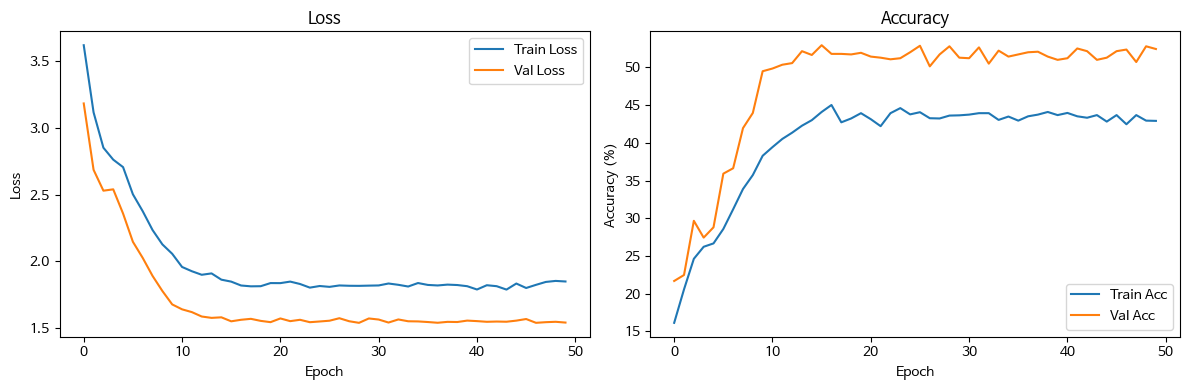

best_epoch,▁▁▂▃▄▄▅▅▆▆▇▇█
best_val_accuracy,▁▁▃▄▄▆▆▇▇▇▇██
dataset/test_samples,▁
dataset/total_samples,▁
dataset/train_samples,▁
dataset/val_samples,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
final/best_val_accuracy,▁
final/final_val_accuracy,▁
final/total_epochs,▁
+5,...


학습 완료! 최고 검증 정확도: 52.95%
모델 저장 경로: /content/drive/MyDrive/modeling_yolo/resnet152_20250918_203333


('/content/drive/MyDrive/modeling_yolo/resnet152_20250918_203333',
 52.945402298850574)

In [20]:
run_modeling_with_wandb()